# In this notebook
I show how to convert a shapefile into a rasterized dataset.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from rasterio.features import rasterize

In [2]:
# We first load the shapefile, then set the coordinate reference system.
gdf = gpd.read_file("../data/durham_july_2023/durham_july_2023_block_group.shp")
gdf.set_crs(epsg=4326, inplace=True)
gdf.to_crs(epsg=3857, inplace=True)

The next cell converts the shape file into a rasterized geometry.

In [4]:

# Read the raster file that will be used as a template
with rio.open("../data/july2023_eve.tif") as src:
    out_meta = src.meta.copy()
    orig_data_shape = src.read(1).shape
    out_image, out_transform = mask(src, gdf.geometry, crop=False)

# Update the metadata for the output raster
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Burn the shapefile into the raster
with rio.open("output_raster.tif", "w", **out_meta) as dest:
    shapes = ((geom, val) for geom, val in zip(gdf.geometry, gdf['m2_temp']) )  # Burn value of 1
    burned = rasterize(shapes=shapes, fill=0, out=out_image, transform=out_transform)
    dest.write_band(1, burned[0, :, :])

Let's confirm that this looks right!

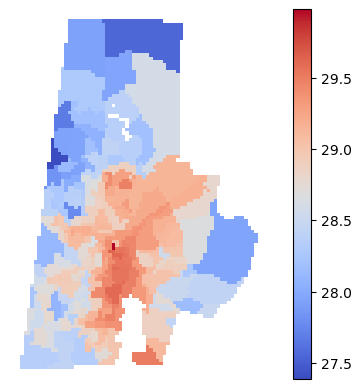

In [5]:
with rio.open('output_raster.tif') as src:
    data = src.read(1)

data[data < 0] = np.nan
plt.imshow(data, cmap='coolwarm')
plt.colorbar()
plt.axis('off')
assert data.shape == orig_data_shape